## **ENTITY VALUE EXTRACTION**

### 0. SETTING UP

In [1]:
import os
import cv2

In [2]:
# DATABASE LOCATION
dataset_path = "data/"

train_path = dataset_path + "train.csv"
test_path = dataset_path + "test.csv"
sample_test_path = dataset_path + "sample_test.csv"

In [3]:
# test if paths exist
import os

for path in [train_path, test_path, sample_test_path]:
    if not os.path.exists(path):
        print(f"Missing CSV File: {path}")

### 1. HELPER FUNCTIONS

In [4]:
def display_image(image):
    plt.figure(figsize = (10, 5))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
def find_all_indices(s, substring):
    pattern = re.compile(re.escape(substring))
    matches = pattern.finditer(s)
    return [match.start() for match in matches]

In [6]:
from IPython.display import HTML, display

In [7]:
def make_clickable_path(path):
    if os.path.exists(path):
        return f'<a href="{path}" target="_blank">{path}</a>'
    else:
        return f'Path does not exist: {path}'

def display_path(path):
    display(HTML(make_clickable_path(path)))

### 2. TRAINING

In [8]:
import re
from PIL import Image
import matplotlib.pyplot as plt

from paddleocr import PaddleOCR, draw_ocr

from constants import unit_variations, entity_unit_map

In [9]:
image_path = dataset_path + "special_images/image_2.jpg"
image_entity = "item_weight"
font_path = "fonts/latin.ttf"

#### (i) PREPROCESSING

In [10]:
image = cv2.imread(image_path)

In [11]:
def preprocess_image(image_in):
    image_out = cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB)
    # image_out = cv2.cvtColor(image_in, cv2.COLOR_BGR2GRAY)
    """
    pre process some tings
    """

    return image_out

In [12]:
image = preprocess_image(image)

Preprocessed Image


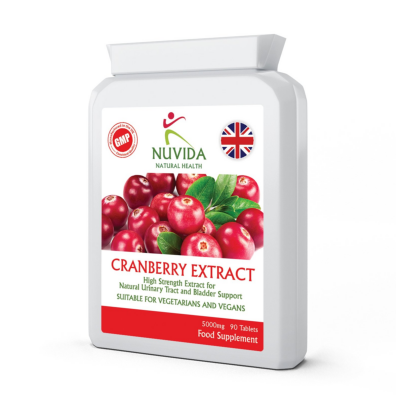

In [13]:
print("Preprocessed Image")
display_image(image)

#### (ii) TEXT RECOGNITION

In [14]:
ocr = PaddleOCR(use_angle_cls=True, lang='en')

[2024/09/15 00:34:32] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\gpshr/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\gpshr/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6

In [15]:
def get_ocr(image_array, cls_in):
    return ocr.ocr(image_array, cls = cls_in)

In [16]:
def show_ocr(image_in, result):
    boxes = [item[0] for item in result[0]]
    texts = [item[1][0] for item in result[0]]
    scores = [item[1][1] for item in result[0]]

    im_show = draw_ocr(image_in, boxes, texts, scores, font_path="fonts/latin.ttf")
    display_image(im_show)

In [17]:
result = ocr.ocr(image)

[2024/09/15 00:34:38] ppocr DEBUG: dt_boxes num : 9, elapsed : 1.064728021621704
[2024/09/15 00:34:39] ppocr DEBUG: cls num  : 9, elapsed : 0.059470176696777344
[2024/09/15 00:34:39] ppocr DEBUG: rec_res num  : 9, elapsed : 0.0535123348236084


OCR Output:


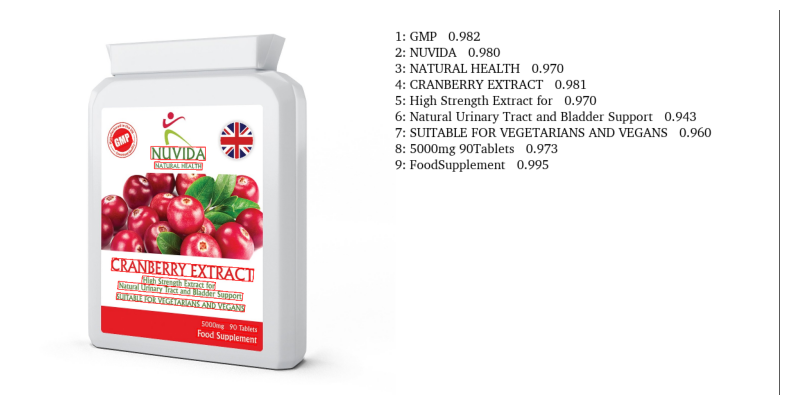

In [18]:
print("OCR Output:")
show_ocr(image, result)

#### (iii) POST PROCESSING

In [19]:
def extract(result_in, entity_name):
    extracted_measurements = []

    for r in result_in[0]:
        location, line = r
        text = line[0]

        for unit in entity_unit_map[entity_name]:
            for rep in unit_variations[unit]:
                indices = find_all_indices(text.lower(), rep.lower())

                for index in indices:
                    if index <= 0:
                        continue

                    numbers = [""]
                    reformat = text[:index].replace(' ', '')

                    i = len(reformat) - 1

                    while (i >= 0) and (reformat[i].isnumeric() or reformat[i] in ['-', '.', ',']):
                        char = reformat[i]

                        if char.isnumeric():
                            numbers[-1] = char + numbers[-1]
                        elif char in ['.', ',']:
                            numbers[-1] = '.' + numbers[-1]
                        elif char in ['-']:
                            numbers.append("")

                        i -= 1

                    discard_rule = lambda x: len(x.strip().replace('.', '')) > 0
                    # print(numbers)
                    numbers = filter(discard_rule, numbers)
                    numbers = sorted(list(map(lambda x: float(x), numbers)))

                    if len(numbers) == 0:
                        continue

                    measurement = f"[{numbers[0]}, {numbers[1]}] {unit}" if len(numbers) > 1 else f"{numbers[0]} {unit}"
                    extracted_measurements.append(measurement)

    return extracted_measurements

In [20]:
extract(result, image_entity)

['90.0 ton', '5000.0 milligram']

### 3. VALIDATION

In [21]:
import pandas as pd

In [22]:
from IPython.display import clear_output

In [23]:
image_folder = "data/train_images/"
validation_path = "data/downloaded_train.csv"

In [24]:
validation = pd.read_csv(validation_path)

In [25]:
def debug_output(image_path, e_value, p_list, p_value):
    display_path(image_path)
    show_ocr(original_image, ocr_result)
    print("expected value:", entity_value)
    print("predicted list:", p_list)
    print("prediction value:", p_value)

[2024/09/15 00:35:04] ppocr DEBUG: dt_boxes num : 65, elapsed : 0.04151606559753418
[2024/09/15 00:35:04] ppocr DEBUG: cls num  : 65, elapsed : 0.06952929496765137
[2024/09/15 00:35:04] ppocr DEBUG: rec_res num  : 65, elapsed : 0.1315140724182129
15/9999


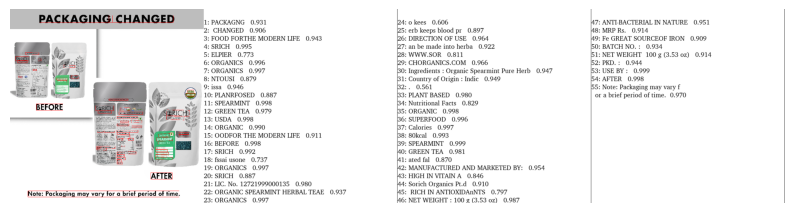

expected value: 53 ounce
predicted list: ['3.53 ounce', '100.0 gram', '3.53 ounce', '100.0 gram']
prediction value: 3.53 ounce


In [26]:
for index, row in validation.iterrows():
    if not row["downloaded"]:
        continue

    image_name = os.path.basename(row["image_link"])
    image_path = image_folder + image_name

    entity_name = row["entity_name"]
    entity_value = row["entity_value"]

    original_image = cv2.imread(image_path)
    image_array = preprocess_image(original_image)
    ocr_result = get_ocr(image_array, cls_in = True)

    try:
        predictions = extract(ocr_result, entity_name)
        pred_value = list(predictions)[0] if len(predictions) > 0 else ""
    except Exception as e:
        print(e)
        print(f"{index + 1}/{len(validation) - 1}")
        debug_output(image_path, entity_value, None, None)

        break

    if pred_value.strip() != entity_value.strip():
        print(f"{index + 1}/{len(validation) - 1}")
        debug_output(image_path, entity_value, predictions, pred_value)

        choice = input("continue [y]: ")
        if len(choice.strip()) > 0:
            break

    clear_output(wait = True)